# **Trabajo de Fin de Máster**
## **Máster de Inteligencia Artificial**
## **Universidad Internacional de Valencia**



**TEMA:** Detección de Deepfakes\
**ALUMNO:** Edgar Roberto Valarezo Vargas\
**DIRECTOR DE TFM:** José Antonio Lagares Rodríguez

**CURSO ACADÉMICO:** 2025

Este cuaderno de Google Colab contiene el flujo de trabajo del proyecto de detección de deepfakes, mostrando los pasos seguidos para construir un prototipo funcional, documentando tanto la metodología como los resultados obtenidos.

A lo largo de las celdas se presentan las fases de preparación del entorno, análisis y preprocesamiento de datos, definición del modelo de red neuronal, entrenamiento y evaluación de métricas de rendimiento.

# **Carga de librerías**

In [ ]:
## Importación de librerías

import os, cv2, sys
from google.colab import drive
from pathlib import Path
import argparse # Para el ingreso de parametros desde CLI

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow y Keras para establecer el modelo
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers #redes convolucionales
from tensorflow.keras.utils import plot_model

# Para versiones anteriores de Keras
import keras
from keras import layers, regularizers, utils

# Métricas de sklearn para evaluar: aciertos/errores, curva ROC (puntos y área) y rendimiento
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve, precision_recall_fscore_support

# **Carga del dataset de imágenes y definición de parámetros globales**

**Estructura de las carpetas:** \
proyecto\
│\
├─ TFM_deepfake_detector_v1.0.ipynb\
├─ dataset/\
│ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ train/\
│ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; │ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ├─ real/\
│ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; │ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; └─ fake/\
│ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ├─ val/\
│ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; │ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ├─ real/\
│ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; │ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; └─ fake/\
│ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; └─ test/\
│  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  ├─ real/\
│   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; └─ fake/\
└─ output/\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;  ├─ best_model.keras\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  &nbsp;&nbsp;&nbsp; ├─ last_model.keras\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  &nbsp;&nbsp;&nbsp; └─ gradcam_samples/


In [ ]:
# Uso de Google Drive como almacenamiento de imágenes para entrenamiento del modelo

drive.mount('/content/drive', force_remount=True)

# Colocar la ruta dentro de Google drive
# ROOT = Path("/content/drive/MyDrive/00 VIU-Inteligencia Artificial/000 TFM 2025/03 TFM/Colab")
ROOT = Path("/content/drive/")

DATASET_NAME = "dataset_reduced_v3"
MODEL_NAME = "output_v8"
OUTPUT_NAME  = "output_v8"

data_dir   = (ROOT / DATASET_NAME)
output_dir = (ROOT / OUTPUT_NAME)
last_model = (ROOT / MODEL_NAME) / "last_model.keras"
best_model = (ROOT / MODEL_NAME) / "best_model.keras"

output_dir.mkdir(parents=True, exist_ok=True)

assert data_dir.exists(), f"No existe dataset: {data_dir}"

data_dir   = str(data_dir)
output_dir = str(output_dir)
last_model = str(last_model)
best_model = str(best_model)

print("data_dir  :", data_dir)
print("output_dir:", output_dir)
print("last_model:", last_model)
print("best_model:", best_model)


Mounted at /content/drive
data_dir  : /content/drive/MyDrive/00 VIU-Inteligencia Artificial/000 TFM 2025/03 TFM/Colab/dataset_reduced_v3
output_dir: /content/drive/MyDrive/00 VIU-Inteligencia Artificial/000 TFM 2025/03 TFM/Colab/output_v8
last_model: /content/drive/MyDrive/00 VIU-Inteligencia Artificial/000 TFM 2025/03 TFM/Colab/output_v8/last_model.keras
best_model: /content/drive/MyDrive/00 VIU-Inteligencia Artificial/000 TFM 2025/03 TFM/Colab/output_v8/best_model.keras


In [ ]:
# Calculo automático de cuántos hilos o procesos se usan para que el flujo de datos sea lo más rápido posible en este hardware
AUTOTUNE = tf.data.AUTOTUNE

# Semilla aleatoria
SEED = 42

# **MÓDULO 1: Preprocesamiento de imágenes**

## **Funciones de preprocesamiento de imágenes**

In [ ]:
## Preprocesado y aumento de variedad de datos

# Tamaño al que se redimensionarán las imágenes
rescale_size = 224

# Función para aplicar un efecto de desenfoque a la imagen
def _blur_image(img, amount=0.25):

    # Aplica un promedio 2D (filtro de suavizado) sobre la imagen
    blur = tf.nn.avg_pool2d(img, ksize=3, strides=1, padding="SAME")[0]

    # Combina la imagen original con la desenfocada para resaltar bordes
    return tf.clip_by_value(img + amount * (img - blur), 0.0, 1.0)


# Función de preprocesamiento de imágenes para la evaluación
def preprocess_eval_image(image, label):

    # Redimensionar la imagen al tamaño definido (224x224)
    image = tf.image.resize(image, (rescale_size, rescale_size))

    # Normalización de la imagen a valores de 0.0 a 1.0 en formato float32
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Aplicar el desenfoque personalizado para mejorar bordes
    image = _blur_image(image, amount=0.20)

    # Retorno de la imagen preprocesada y la etiqueta
    return image, label


# Función de aumento de datos para el entrenamiento
def augment(image, label):

    # Convertir valores de [0,255] a [0,1] en float32
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Volteo horizontal aleatorio
    image = tf.image.random_flip_left_right(image)

    # Ajuste de brillo aleatorio (variación de hasta 0.10)
    image = tf.image.random_brightness(image, max_delta=0.10)

    # Cambio de contraste aleatorio (entre 0.90 y 1.10)
    image = tf.image.random_contrast(image, lower=0.90, upper=1.10)

    # Aplica el desenfoque para simular variaciones
    image = _blur_image(image, amount=0.20)

     # Aseguramiento de que los valores se mantengan en el rango válido [0,1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    # Retorno de la imagen aumentada y su etiqueta
    return image, label

## **Funciones de carga y creación de datasets de entrenamiento y validación, *data augmentation***

In [ ]:
# Función para crear datasets de entrenamiento y validación a partir de un directorio

def make_train_val(data_dir, img_size, batch):

    # Definir las rutas de las carpetas "train" y "val"
    train_dir = os.path.join(data_dir, "train")
    val_dir = os.path.join(data_dir, "val")

    # Crea el dataset de entrenamiento a partir de las imágenes en la carpeta "train"
    train_ds = keras.utils.image_dataset_from_directory(
        train_dir,                        # Ruta de las imágenes de entrenamiento
        labels="inferred",                # Infiere etiquetas según las carpetas
        label_mode="binary",              # Clasificación binaria (0 o 1)
        image_size=(img_size, img_size),  # Redimensiona las imágenes al tamaño
        batch_size=batch,                 # Número de imágenes por batch
        seed=SEED                         # Semilla para reproducibilidad
    )

    # Crea el dataset de validación a partir de las imágenes en la carpeta "val"
    val_ds = keras.utils.image_dataset_from_directory(
        val_dir,                          # Ruta de las imágenes de validación
        labels="inferred",
        label_mode="binary",
        image_size=(img_size, img_size),
        batch_size=batch,
        seed=SEED,
        verbose=0,
        shuffle=False                     # No mezclar para mantener el orden en validación
    )


    # Función para normalizar imágenes (sin aumento de datos)
    def normalize_only(x, y):

        x = tf.image.convert_image_dtype(x, tf.float32) # Convierte a float32 y escala [0,1]
        return x, y

    ## Pipeline: train = augment y normalizar, val = solo normalizar

    # Aplicar augmentación al dataset de entrenamiento
    train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)

    # Mezclar el dataset de entrenamiento, con prefetch se optimiza el rendimiento
    train_ds = train_ds.shuffle(8*batch, seed=SEED).prefetch(AUTOTUNE)

    # Aplicar normalización al dataset de validación
    val_ds = val_ds.map(normalize_only, num_parallel_calls=AUTOTUNE)

    # Preparar el dataset de validación con prefetch (sin shuffle)
    val_ds   = val_ds.prefetch(AUTOTUNE)

    # Retornar ambos datasets listos para el modelo
    return train_ds, val_ds


## **Funciones de carga y creación de dataset de evaluación**

In [ ]:
# Función para crear un dataset de evaluación (prueba o validación) con preprocesamiento

def make_eval(data_dir, split, img_size, batch):

    # Construir la ruta según el split especificado (ej: "val" o "test")
    split_dir = os.path.join(data_dir, split)

    # Cargar las imágenes desde el directorio
    ds = keras.utils.image_dataset_from_directory(
        split_dir,                        # Ruta del dataset
        labels="inferred",
        label_mode="binary",
        image_size=(img_size, img_size),
        batch_size=batch,
        seed=SEED,
        verbose=0,
        shuffle=False
    )

    # Guardar las rutas de archivos cargados en una lista
    file_paths = ds.file_paths

    # Aplicar la función de preprocesamiento al dataset y prefetch para optimizar rendimiento
    ds = ds.map(preprocess_eval_image, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

    # Obtener los nombres de las clases (carpetas del directorio) y ordenarlas
    class_names = sorted(next(os.walk(split_dir))[1])

    # Retorno del dataset procesado, rutas de archivos y nombres de clases
    return ds, file_paths, class_names

# **MODULO 2: Extracción y análisis de características**

## **Funciones de atención visual por canal y espacial, CBAM**

In [ ]:
# Registrar la clase como serializable para que Keras pueda guardar/cargar en modelos
@keras.utils.register_keras_serializable(package="Custom", name="ChannelAttention")

# Definición de una capa de atención por canal
class ChannelAttention(layers.Layer):

    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)  # Constructor de la clase padre
        self.ratio = ratio                                # Ratio de reducción de dimensión de canales del MLP


    def build(self, input_shape):
        channel_dim = input_shape[-1]                     # Número de canales de entrada
        hidden_units = max(channel_dim // self.ratio, 1)  # Definición de unidades ocultas reduciendo por el ratio

        # Definición de capas densas: para reducir dimensión y luego recuperar
        self.fc1 = layers.Dense(hidden_units, activation="relu")
        self.fc2 = layers.Dense(channel_dim, activation="sigmoid")

        # Operaciones de pooling global por canal
        self.avg_pool = layers.GlobalAveragePooling2D()
        self.max_pool = layers.GlobalMaxPooling2D()


    def call(self, inputs):
        # Aplicar pooling global a los canales
        avg_out = self.fc2(self.fc1(self.avg_pool(inputs))) # paso por MLP después del avg_pool
        max_out = self.fc2(self.fc1(self.max_pool(inputs))) # paso por MLP después del max_pool

        # Expandie las dimensiones para igualar al tensor original
        avg_out = tf.expand_dims(tf.expand_dims(avg_out, 1), 1)
        max_out = tf.expand_dims(tf.expand_dims(max_out, 1), 1)

        # Retorno de la entrada por la atención (avg + max)
        return inputs * (avg_out + max_out)


In [ ]:
# Registrar la clase como serializable para que Keras pueda guardar/cargar en modelos
@tf.keras.utils.register_keras_serializable(package = "Custom", name = "SpatialAttention")

# Definición de una capa de atención espacial
class SpatialAttention(layers.Layer):

    def __init__(self, kernel_size=7, **kwargs):

        super().__init__(**kwargs)            # Constructor de la clase padre
        self.kernel_size = kernel_size        # Se guarda el tamaño del kernel para convolución


    def build(self, input_shape):

        self.conv = layers.Conv2D(            # Define una convolución 2D con un filtro para generar el mapa de atención espacial
            filters = 1,                      # Un canal de salida (máscara de atención)
            kernel_size = self.kernel_size,   # Tamaño del kernel
            strides = 1,                      # Desplazamiento estándar de 1
            padding = "same",                 # No cambia las dimensiones de la entrada
            activation = "sigmoid",           # Para la salida entre [0,1] de la máscara
            kernel_initializer = "he_normal", # Inicialización de pesos de la CNN
            use_bias = False                  # No usa sesgo en esta convolución
        )

        # Finalizar la construcción de la capa base
        super().build(input_shape)


    def call(self, inputs):

        # Calculo del promedio por canal (mapa de información)
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)

        # Calculo del máximo por canal (mapa de características fuertes)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)

         # Concatenar mapas en el eje de canales
        both = tf.concat([avg_pool, max_pool], axis=-1)

        # Pasa el resultado por la convolución para generar la máscara de atención
        mask = self.conv(both)

        # Retorno de la multiplicación de la entrada original por la máscara
        # para realzar regiones importantes
        return inputs * mask


    def get_config(self):

        # Guardado de la configuración para que la capa pueda ser serializada correctamente
        config = super().get_config()
        config.update({"kernel_size": self.kernel_size})

        return config

In [ ]:
# Registrar la clase como serializable para que Keras pueda guardar/cargar en modelos
@keras.utils.register_keras_serializable(package="Custom", name="CBAM")

# Definición de la clase CBAM como una capa Keras
class CBAM(layers.Layer):

    def __init__(self, reduction=16, kernel_size=7, **kwargs):
        super().__init__(**kwargs)                    # Constructor de la clase padre
        self.reduction = reduction                    # Parámetro para compresión de canales de ChannelAttention
        self.kernel_size = kernel_size or 7

    # Definición de las subcapas de atención que forman CBAM
    def build(self, input_shape):

        self.channel_attention = ChannelAttention(self.reduction)       # Atención por canal
        self.spatial_attention = SpatialAttention(self.kernel_size)     # Atención espacial

        # Finalizar la construcción de la capa base
        super().build(input_shape)


    def call(self, inputs):

        x = self.channel_attention(inputs)            # Aplicar atención por canal
        x = self.spatial_attention(x)                 # Aplicar atención espacial

        # Retorno de la salida refinada en ambas dimensiones
        return x


## **Función de construcción del modelo**



In [ ]:
def build_model(img_size=224):

    # Capa de entrada para imágenes RGB (3 canales) de tamaño img_size x img_size
    inputs = keras.Input(shape=(img_size, img_size, 3))

    # Primer bloque convolucional
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)   # 32 filtros, tamaño de kernel 3x3, padding “same” mantiene tamaño, activación ReLU
    x = layers.BatchNormalization()(x)                                    # Normaliza por lotes para estabilizar y acelerar el entrenamiento
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)        # Segunda conv 3x3 con 32 filtros para extraer más características
    x = layers.MaxPool2D()(x)                                             # Reduce el tamaño espacial (alto/ancho) a la mitad reteniendo información relevante

    # Segundo bloque convolucional
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)        # 64 filtros
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPool2D()(x)

    # Tercer bloque convolucional
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)       # 128 filtros
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPool2D()(x)

    # Aplicación de función de atención CBAM para refinar canales y regiones importantes
    x = CBAM()(x)

    # Clasificador denso
    x = layers.Flatten()(x)                     # Convierte los mapas de características en un vector 1D
    x = layers.Dropout(0.3)(x)                  # Desactiva aleatoriamente 30% para evitar sobreajuste
    x = layers.Dense(128, activation="relu")(x) # Capa densa totalmente conectada de 128 neuronas con activación ReLU

    # Capa de salida
    x = layers.Dropout(0.3)(x) # Segundo dropout de 30% de neuronas para evitar sobreajuste
    outputs = layers.Dense(1, activation="sigmoid")(x) # Salida binaria (0 = real, 1 = fake) con activación sigmoide para producir probabilidad

    # Modelo final
    model = keras.Model(inputs, outputs, name="deepfake_detector")

    return model

## **UTILIDADES: Funciones de Grad-CAM y detección de última convolución**

In [ ]:
# Función para generar un mapa de calor con Grad-CAM
def gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    img_array = tf.cast(img_array, tf.float32)      # Asegura que img_array es float32

    if len(img_array.shape) == 3:                   # Si la imagen tiene formato (Height, Width, Channels)
        img_array = tf.expand_dims(img_array, 0)    # Añadir dimensión batch (1, H, W, C)

    # Modelo auxiliar
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output] # Activaciones de la última capa convolucional, salida del modelo
    )

    # Guardar operaciones para calcular gradientes
    with tf.GradientTape() as tape:

        conv_outputs, predictions = grad_model(img_array)   # Activaciones y predicciones

        if pred_index is None:
            pred_index = tf.argmax(predictions[0])          # Clase con mayor probabilidad

        class_channel = predictions[:, pred_index]          # Probabilidad de clase objetivo

    # Cálculo de gradientes de clase respecto a las activaciones de la capa conv
    grads = tape.gradient(class_channel, conv_outputs)

    # Promedio de gradientes por canal, indica la importancia de cada mapa de características
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]                          # Eliminar dimensión batch
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]  # Multiplicar activaciones por la importancia de cada canal
    heatmap = tf.squeeze(heatmap)                           # Eliminar dimensiones extra

    max_val = tf.reduce_max(heatmap)                        # Normalizar heatmap a [0,1]

    if max_val > 0:
        heatmap /= max_val
    heatmap = np.uint8(255 * heatmap.numpy())               # Transforma a rango [0,255]

    # Normalización adicional para asegurar valores válidos
    heatmap = tf.maximum(heatmap, 0)

    if tf.reduce_max(heatmap) > 0:
        heatmap /= tf.reduce_max(heatmap)

    # Convertir a uint8 2D nuevamente
    heatmap = np.uint8(255 * heatmap.numpy())

    if heatmap.ndim == 3:   # Si tiene forma (H, W, 1) se reduce a (H, W)
        heatmap = heatmap[:, :, 0]

    # Retornar mapa de calor para superponer en la imagen
    return heatmap

In [ ]:
# Función para superponer un mapa de calor (Grad-CAM) sobre la imagen original
def overlay_heatmap(img_uint8, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):

    # Ajusta el tamaño del heatmap al de la imagen original
    heatmap = cv2.resize(heatmap, (img_uint8.shape[1], img_uint8.shape[0]))

    # Convierte el heatmap en una versión a color usando colormap JET
    heatmap_color = cv2.applyColorMap(heatmap, colormap)

    # Combina la imagen original con el heatmap de color con transparencia (alpha)
    return cv2.addWeighted(img_uint8, 1 - alpha, heatmap_color, alpha, 0)

In [ ]:
# Función para localizar la última capa convolucional adecuada para Grad-CAM

def find_last_conv(model, prefer_size_min=7):
    candidate = None      # Valor por defecto si no se encuentra

    # Recorre las capas del modelo en orden inverso
    for layer in reversed(model.layers):

       if isinstance(layer, keras.layers.Conv2D):       # Verifica si la capa es Conv2D
            # print(layer.name, layer.output.shape)     # (Opcional, para debug)

            try:
                h, w = layer.output_shape[1], layer.output_shape[2]     # Alto y ancho del feature map
                if h >= prefer_size_min and w >= prefer_size_min:       # Si el tamaño es mayor o igual al preferido
                    return layer.name                                   # Se devuelve la capa
            except:
                pass                                                    # En caso de no poder acceder al output_shape

            if candidate is None:
                candidate = layer.name              # Si aún no hay candidato, se devuelve la capa actual

    # Si se encuentra una Conv2D pero ninguno con tamaño grande, devuelve el último
    if candidate:
        return candidate

    # Error devuelto si no hay ninguna capa Conv2D en el modelo
    raise ValueError("No se encontró una capa Conv2D en el modelo.")

# **MÓDULO 3: Clasificación y explicabilidad**

## **Función de entrenamiento del modelo**

In [ ]:
def do_train(args):

    # Preparar el conjunto de datos de entrenamiento y validación
    print("[INFO] Preparando dataset de entrenamiento y validación.")
    train_ds, val_ds = make_train_val(args.data_dir, args.img_size, args.batch_size)

    # Construir el modelo con el tamaño de imagen indicado
    print("[INFO] Creando el modelo.")
    model = build_model(args.img_size)

    # Compilar el modelo con optimizador, función de pérdida y métricas
    print("[INFO] Compilando el modelo.")
    model.compile(
        optimizer=keras.optimizers.Adam(args.lr),           # Optimizador Adam con tasa de aprendizaje
        loss="binary_crossentropy",                         # Pérdida binaria para clasificación 0 o 1
        metrics=[keras.metrics.BinaryAccuracy(name="acc"),  # Métricas de evaluación durante el entrenamiento
                 keras.metrics.AUC(name="auc"),
                 keras.metrics.Precision(name="prec"),
                 keras.metrics.Recall(name="recall")]
    )

    # Crear el directorio de salida para guardar modelos
    os.makedirs(args.output_dir, exist_ok=True)

    # Guardar modelo que obtiene el mejor rendimiento según la métrica de validación (val_auc).
    checkpoint_path = os.path.join(args.output_dir, "best_model.keras")

    # Callbacks de entrenamiento
    callbacks = [

        # Guarda el modelo cada vez que mejora el val_auc. Sólo se conserva el mejor
        keras.callbacks.ModelCheckpoint(checkpoint_path, monitor="val_auc", mode="max", save_best_only=True, verbose=1),

        # Detiene el entrenamiento si val_auc deja de mejorar durante 5 épocas seguidas, restaura los pesos del mejor modelo
        keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True),

        # Reduce LR a la mitad si la val_loss no mejora durante 3 épocas consecutivas, evita estancamiento
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    ]

    # Entrenar el modelo con los datasets
    print("[INFO] Entrenando.")

    # Guardar el historial del entrenamiento de TRAIN y VAL por época, para curvas de aprendizaje y medición de desempeño
    history = model.fit(train_ds, validation_data=val_ds, epochs=args.epochs, callbacks=callbacks, verbose=2)

    # Guardar el último modelo entrenado al fin de épocas, como respaldo
    last_path = os.path.join(args.output_dir, "last_model.keras")
    model.save(last_path)

    print(f"[OK] Entrenamiento listo. Mejor modelo: {checkpoint_path}. Último: {last_path}")

    # Retornar historial de entrenamiento: pérdidas y métricas por época
    return history

## **Función de umbral F1**

In [ ]:
# Cálculo del mejor umbral F1 para clasificación binaria

def do_ypred(args):

    print("[INFO] Cargando modelo.")

    # Registro de las capas personalizadas para cargar el modelo
    custom_objects = {
        "CBAM": CBAM,
        "ChannelAttention": ChannelAttention,
        "SpatialAttention": SpatialAttention
    }

    # Carga del modelo entrenado con las capas personalizadas
    model = keras.models.load_model(args.model_path, custom_objects=custom_objects, compile=False)

    # Compilar el modelo
    model.compile(optimizer=keras.optimizers.Adam(1e-4),    # Optimizador Adam con tasa de aprendizaje
                  loss="binary_crossentropy",               # Pérdida binaria para clasificación 0 o 1
                  metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()]) # Métricas de evaluación para calculo de accuracy y ROC

    print("[INFO] Preparando datos de cálculo de umbral.")

    # Evaluación del conjunto de Validación para buscar el umbral óptimo
    val_ds, file_paths, class_names = make_eval(args.data_dir, "val", args.img_size, args.batch_size)

    # Obtener probabilidades para cada imagen
    y_prob = model.predict(val_ds, verbose=0).ravel()

    # Extraer las etiquetas verdaderas (0 = real, 1 = fake)
    y_true = [y.numpy().item() for _, y in val_ds.unbatch()]
    y_true = np.array(y_true)

    print("[INFO] Calculando umbral.")

    # Calcular precisión, recall y umbrales
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)

    # Calcular F1 en cada punto (se agrega 1e-8 para evitar división por cero)
    f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

    # Encontrar el mejor umbral según F1
    best_idx = np.argmax(f1s)
    best_threshold = thresholds[best_idx]

    # Mostrar resultados
    print("[OK] Resultado:")
    print(f"Mejor umbral: {best_threshold:.2f}")

    # Graficar métricas según umbral
    plt.figure(figsize=(8,6))
    plt.plot(thresholds, precisions[:-1], label="Precisión")
    plt.plot(thresholds, recalls[:-1], label="Recall")
    plt.plot(thresholds, f1s[:-1], label="F1-score", linewidth=2)

    plt.axvline(best_threshold, color="r", linestyle="--", label=f"Óptimo = {best_threshold:.2f}")  # Línea vertical en el mejor umbral

    plt.xlabel("Umbral")
    plt.ylabel("Métrica")
    plt.title("Precisión, Recall y F1 en función del umbral")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(args.output_dir, "umbral.png"), dpi=200)
    plt.show()

    return best_threshold

## **Función del modelo de evaluación, gráficas y Grad-CAM**

In [ ]:
def do_eval(args, threshold=0.5):

    print("[INFO] Inicio de evaluación del modelo.")
    print("[INFO] Cargando modelo.")

    # Registro de las capas personalizadas para cargar el modelo
    custom_objects = {
        "CBAM": CBAM,
        "ChannelAttention": ChannelAttention,
        "SpatialAttention": SpatialAttention
    }

    # Carga del modelo entrenado con las capas personalizadas
    model = keras.models.load_model(args.model_path, custom_objects=custom_objects, compile=False)

    # Compilar el modelo
    model.compile(optimizer=keras.optimizers.Adam(1e-4),
                  loss="binary_crossentropy",
                  metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()])

    print("[INFO] Preparando datos.")

    # Carga del dataset con etiquetas y rutas
    ds, file_paths, class_names = make_eval(args.data_dir, "test", args.img_size, args.batch_size)

    print("[INFO] Calculando predicciones.")

    # Cálculo de predicción de probabilidades para cada imagen
    y_prob = model.predict(ds, verbose=0).ravel()

    # Etiquetas verdaderas
    y_true = [y.numpy().item() for _, y in ds.unbatch()]
    y_true = np.array(y_true)

    # Clasificación binaria según un umbral encontrado
    y_pred = (y_prob >= threshold).astype(int)

    # Cálculo de métricas
    acc = accuracy_score(y_true, y_pred)                      # Exactitud
    prec = precision_score(y_true, y_pred, zero_division=0)   # Precisión
    rec = recall_score(y_true, y_pred, zero_division=0)       # Recall
    f1 = f1_score(y_true, y_pred, zero_division=0)            # F1
    fpr, tpr, _ = roc_curve(y_true, y_prob)                   # Curva ROC
    roc_auc = auc(fpr, tpr)                                   # Área bajo la curva ROC (AUC)
    cm = confusion_matrix(y_true, y_pred)                     # Matriz de confusión

    # Creamción del directorio de salida
    os.makedirs(args.output_dir, exist_ok=True)

    # Guardar resultados por cada imagen en archivo CSV
    df = pd.DataFrame({
        "file_path": file_paths,
        "y_true": y_true,
        "y_prob_fake": y_prob,
        "y_pred": y_pred})

    df.to_csv(os.path.join(args.output_dir, "reporte_val_por_muestra.csv"), index=False)

    # Guardar métricas globales en resumen TXT
    with open(os.path.join(args.output_dir, "metricas_resumen.txt"), "w", encoding="utf-8") as f:
        f.write(f"""Accuracy: {acc:.4f}\n
                  Precision: {prec:.4f}\n
                  Recall: {rec:.4f}\n
                  F1: {f1:.4f}\n
                  AUC: {roc_auc:.4f}\n""")

        f.write(f"Confusion Matrix:\n{cm}\n")

    print("[INFO] Graficando.")

    # GRÁFICAS

    # Gráfica de matriz de confusión
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title("Matriz de confusión")
    plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.savefig(os.path.join(args.output_dir, "matriz_confusion.png"), dpi=200)
    plt.close()

    # Gráfica de Curva ROC
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title("Curva ROC")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(os.path.join(args.output_dir, "curva_roc.png"), dpi=200)
    plt.close()

    print(f"[OK] Resultados:")
    print(f"Accuracy  = {acc:.4f}")
    print(f"Precision = {prec:.4f}")
    print(f"Recall    = {rec:.4f}")
    print(f"F1        = {f1:.4f}")
    print(f"AUC       = {roc_auc:.4f}")


    # GRAD-CAM

    print("[INFO] Generando Grad-CAM de algunas imágenes.")

    # Grad-CAM de imágenes al azar
    gradcam_dir = os.path.join(args.output_dir, "gradcam_samples")
    os.makedirs(gradcam_dir, exist_ok=True)

    # Localizar última capa convolucional adecuada
    last_conv = find_last_conv(model)
    # last_conv = "conv2d_22"  # (alternativa manual)

    samples_guardados = 0
    max_samples = args.gradcam_samples    # Número de samples a guardar

    # Itera por cada clase del conjunto de validación (fake/real)
    for cls in sorted(next(os.walk(os.path.join(args.data_dir, "test")))[1]):

        cls_dir = os.path.join(args.data_dir, "test", cls)

        # Listar imágenes de la clase
        files = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        # Procesa varias imágenes por clase (mitad de max_samples)
        for fname in files[: max(1, max_samples // 2)]:
            p = os.path.join(cls_dir, fname)

            # Decodificar la imagen con TensorFlow
            raw = tf.io.read_file(p)
            img = tf.image.decode_image(raw, channels=3)
            img = tf.image.convert_image_dtype(img, tf.float32)

            # Redimensionar la imagen al tamaño esperado por el modelo y overlay
            img_resized = tf.image.resize(img, (args.img_size, args.img_size))

            # Convierte a uint8 para overlay con OpenCV
            img_uint8 = (img_resized.numpy() * 255).astype("uint8")

            # Añadir dimensión batch (1, H, W, C)
            img_res = tf.expand_dims(img_resized, 0)

            # Calcular mapa de calor con Grad-CAM y overlay
            preds = model.predict(img_res, verbose=0)
            pred_index = np.argmax(preds[0])   # Clase más probable según el modelo

            # Generar el mapa de calor con Grad-CAM
            heat = gradcam_heatmap(img_res, model, last_conv, pred_index=pred_index)

            # Superposición de mapa de calor sobre imagen, con transparencia
            overlay = overlay_heatmap(img_uint8, heat, alpha=0.35)

            # Guardar resultados
            out_path = os.path.join(gradcam_dir, f"gradcam_{os.path.basename(p)}")
            plt.figure();
            plt.imshow(overlay);
            plt.axis("off");
            plt.tight_layout()
            plt.savefig(out_path, dpi=200, bbox_inches='tight', pad_inches=0);
            plt.close()

            samples_guardados += 1
            if samples_guardados >= max_samples:
                break

    print(f"[OK] Grad-CAM guardados en: {gradcam_dir} ({samples_guardados} imágenes)")


# **Ejecución del entrenamiento**

In [ ]:
# Ejecución del entrenamiento del modelo

args = argparse.Namespace(data_dir=data_dir, output_dir=output_dir, img_size=224, batch_size=32, epochs=10, lr=1e-4)

do_train(args)

[INFO] Preparando dataset de entrenamiento y validación.
Found 60003 files belonging to 2 classes.
[INFO] Creando el modelo.
[INFO] Compilando el modelo.
[INFO] Entrenando.
Epoch 1/10

Epoch 1: val_auc improved from -inf to 0.48866, saving model to /content/drive/MyDrive/00 VIU-Inteligencia Artificial/000 TFM 2025/03 TFM/Colab/output_v8/best_model.keras
1876/1876 - 3932s - 2s/step - acc: 0.6711 - auc: 0.7498 - loss: 0.5841 - prec: 0.6302 - recall: 0.8284 - val_acc: 0.4897 - val_auc: 0.4887 - val_loss: 108.7958 - val_prec: 0.4946 - val_recall: 0.9503 - learning_rate: 1.0000e-04
Epoch 2/10

Epoch 2: val_auc improved from 0.48866 to 0.50988, saving model to /content/drive/MyDrive/00 VIU-Inteligencia Artificial/000 TFM 2025/03 TFM/Colab/output_v8/best_model.keras
1876/1876 - 112s - 59ms/step - acc: 0.7117 - auc: 0.8014 - loss: 0.5293 - prec: 0.6597 - recall: 0.8743 - val_acc: 0.4887 - val_auc: 0.5099 - val_loss: 20.2545 - val_prec: 0.4935 - val_recall: 0.8583 - learning_rate: 1.0000e-04
Ep

[INFO] Cargando modelo.
[INFO] Preparando datos de cálculo de umbral.
[INFO] Calculando umbral.
[OK] Resultado:
Mejor umbral: 0.29


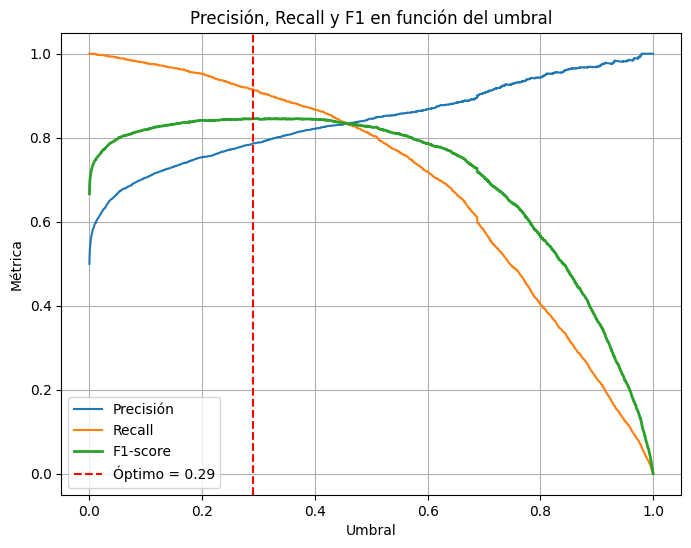

In [ ]:
# Ejecución del cálculo de umbral

args_umbral = argparse.Namespace(
    data_dir=data_dir,
    model_path=best_model,
    output_dir=output_dir,
    img_size=224,
    batch_size=16)

umbral_opt = do_ypred(args_umbral)

In [ ]:
# Ejecución de la evaluación del modelo

args_eval = argparse.Namespace(
    data_dir=data_dir,
    model_path=best_model,
    output_dir=output_dir,
    img_size=224,
    batch_size=32,
    gradcam_samples=40)

do_eval(args_eval, umbral_opt)

[INFO] Inicio de evaluación del modelo.
[INFO] Cargando modelo.
[INFO] Preparando datos.
[INFO] Calculando predicciones.
[INFO] Graficando.
[OK] Resultados:
Accuracy  = 0.6475
Precision = 0.5931
Recall    = 0.9400
F1        = 0.7273
AUC       = 0.7514
[INFO] Generando Grad-CAM de algunas imágenes.
[OK] Grad-CAM guardados en: /content/drive/MyDrive/00 VIU-Inteligencia Artificial/000 TFM 2025/03 TFM/Colab/output_v8/gradcam_samples (40 imágenes)
